<a href="https://colab.research.google.com/github/aliicee3/LOGML2021-Learning-Latent-Geometries/blob/main/ConvolutionalVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-model-summary

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

from sklearn.datasets import fetch_lfw_people
from pytorch_model_summary import summary

# Utility

In [3]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [4]:
standardize = lambda x: transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))(x)

In [87]:
# Modelling Parameters

IMAGE_SHAPE = (3, 112, 96)
LATENT_DIMS = 32

In [6]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preprocessing

In [7]:
# Download Data

lfw_people = fetch_lfw_people("./lfw/", resize=1)

In [74]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((112, 96)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [75]:
# Datalaoder Object

data = dataset_loader("/content/lfw/lfw_home/lfw_funneled")

In [76]:
# A Data batch

X = next(iter(data))[0]

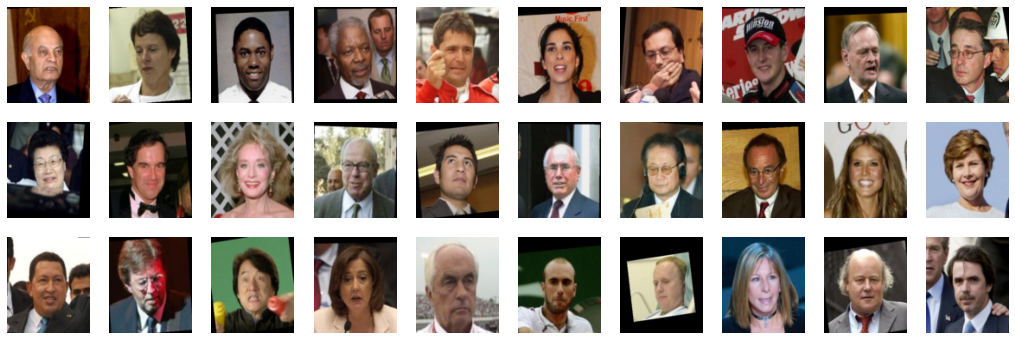

In [77]:
plot_image_samples(X)

In [78]:
# Single Image Shape

X[0].shape

torch.Size([3, 112, 96])

# Modelling

In [95]:
class residualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(residualBlock, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels, track_running_stats=False))
        else:
          self.skip = None

        self.block = nn.Sequential(nn.BatchNorm2d(in_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels, out_channels, 3, padding=1)
                                   )   

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out)

        return out

class EncoderConv(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(EncoderConv, self).__init__()
        
        self.latents = latents
        self.c = c
        
        size = self.c * np.array([2,4,8,16], dtype = np.intc)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_down1 = residualBlock(3, size[0])
        self.dconv_down2 = residualBlock(size[0], size[1])
        self.dconv_down3 = residualBlock(size[1], size[2])
        self.dconv_down4 = residualBlock(size[2], size[3])
        self.dconv_down5 = residualBlock(size[3], size[3])
        
        self.fc_mu = nn.Linear(in_features=size[3]*7*6, out_features=self.latents)
        self.fc_logvar = nn.Linear(in_features=size[3]*7*6, out_features=self.latents)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        x = self.maxpool(x)
        
        x = self.dconv_down5(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        
        return x_mu, x_logvar

class DecoderConv(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(DecoderConv, self).__init__()
        
        self.latents = latents
        self.c = c
        
        size = self.c * np.array([2,4,8,16], dtype = np.intc)
        
        self.fc = nn.Linear(in_features=self.latents, out_features=(self.c*16)*7*6)
          
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = residualBlock(size[3], size[3])
        self.dconv_up3 = residualBlock(size[3], size[2])
        self.dconv_up2 = residualBlock(size[2], size[1])
        self.dconv_up1 = residualBlock(size[1], size[0])
        self.conv_last = nn.Conv2d(size[0], 3, 1)
        
        
    def forward(self, x):        
        x = self.fc(x)

        x = x.view(x.size(0), self.c*16, 7, 6) # unflatten batch of feature vectors to a batch of multi-channel feature maps

        x = self.upsample(x)
        x = self.dconv_up4(x)
        
        x = self.upsample(x)    
        x = self.dconv_up3(x)
      
        x = self.upsample(x)   
        x = self.dconv_up2(x)
        
        x = self.upsample(x)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

class VariationalAutoencoder(nn.Module):
    def __init__(self, latents = 128, c = 4):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderConv(latents, c)
        self.decoder = DecoderConv(latents, c)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu


        self.kl_loss = None
        self.reconstr_loss = None

def vae_loss(recon_x, x, mu, logvar, variational_beta):
    loss_rec = F.mse_loss(recon_x, x) 
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = loss_rec + variational_beta * kldivergence
    
    return loss


In [96]:
# Model Instantiation
device = 'cpu'
model = VariationalAutoencoder().to(device)
X_bar, _, _ = model.forward(X.to(device))

print(summary(model, torch.zeros((1, *IMAGE_SHAPE)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
     EncoderConv-1     [1, 3, 112, 96]         839,414         839,414
     DecoderConv-2            [1, 128]         460,427         460,427
Total params: 1,299,841
Trainable params: 1,299,841
Non-trainable params: 0
-----------------------------------------------------------------------


# Training Loop

In [97]:
# Training Params

opt = torch.optim.Adam(model.parameters())
EPOCHS = 100
THRESHOLD = 1e-4
PATIENCE = 8

history = {'loss': [0]}

In [ ]:
# Custom Training Loop

model.train()

round = 0
loss_inc_count = 0

for epoch in range(EPOCHS):
    count = 0
    tick = time()
    l1, l2 = 0, 0

    for idx, X in enumerate(data):
        count += 1

        # Copy data to Device
        X = X[0].to(device)

        # Forward Pass
        reconstructed_x, mu, log_var = model.forward(X)

        loss = vae_loss(reconstructed_x, X, mu, log_var, 1e-5)
        
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        
        # Apply Jacobians to Weights
        opt.step()

        l1 += loss.item()
        
    # Log Training
    history["loss"].append(l1/count)
    
    # Training Moniotring
    tock = time()
    round += 1
    print(f"""Epoch [{round} / {EPOCHS}] 
    - Loss: {history["recon-loss"][-1]: 0.6f} 
    - Time-Taken: {(tock-tick): 0.6f} sec""", end="\n\n")
    
    # Plot Randomly Sampled Latent Embeddings
    if round%5 == 0:
        plot_image_samples(model.decoder(torch.randn((32, LATENT_DIMS)).to(device)).detach().cpu())
        print()

    # Early Stopping
    if (history["kl-loss"][-1]  - history["kl-loss"][-2] + history["recon-loss"][-1] - history["recon-loss"][-2]) < 0:
        loss_inc_count += 0
    if ((abs(history["kl-loss"][-1]  - history["kl-loss"][-2]) + abs(history["recon-loss"][-1] - history["recon-loss"][-2])) <= THRESHOLD) or (loss_inc_count >= PATIENCE):
        break

In [ ]:
# Training Visualization

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history["recon-loss"])
plt.title("Recostruction Loss")

plt.subplot(1, 3, 2)
plt.plot(history["kl-loss"])
plt.title("KL Loss")

plt.subplot(1, 3, 3)
plt.plot(history["recon-loss"]+history["kl-loss"])
plt.title("Total Loss")

plt.show()

In [ ]:
# Visualizing Latent Space

N = 1000 #No of Parameters
N_sample = 3 #No. of Samples per parameter

# Sampling Images
temp = [next(iter(data)) for _ in range(N//32 + 1)]
X = torch.vstack([x[0] for x in temp])
Y = torch.hstack([x[1] for x in temp])

# Forward Pass through Encoder
mu_, _log_var = model.encoder(X.to(device))

# Sampling from Normal Disitrbution using predicted Parameters
embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()
embedding_class = torch.hstack([Y for _ in range(N_sample)]).detach().cpu().numpy()

# Dimensionality Reduction
low_dim_embeddings = KernelPCA(n_components=2, kernel="poly").fit_transform(embeddings)

# Plotting Principle Components
plt.figure(figsize=(16,8))
plt.scatter(x = low_dim_embeddings[:,0], 
            y = low_dim_embeddings[:, 1], 
            alpha=0.6)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

# Checkpointing

In [ ]:
# Saving Model

# torch.save(model.state_dict(), "./brain-tumor-vae.pt")